# Analysis of diode series expansion coefficient

### by Lucas de Jesus B. Gonçalves

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

## Objetivos

Este notebook tem como principais objetivos trabalhar com 
* Obter os parâmetros para o modelo de Shockley da melhor forma possível, tendo que temos a curva I-V do diodo que queremos modelar
* Validar o modelo de Shockley obtido graficamente
* Comparar o resultado da componente DC de corrente de resposta à um estímulo AC de tensão em um dado diodo, segundo a formulação clássica, e segundo a formulação desenvolvida no trabalho final, envolvendo o uso da função de Bessel modificada de primeira categoria

### Parâmetros

Aquí carregamos os dados da curva de resposta do diodo selecionado. O objetivo é fazer um fitting para a equação de shockley

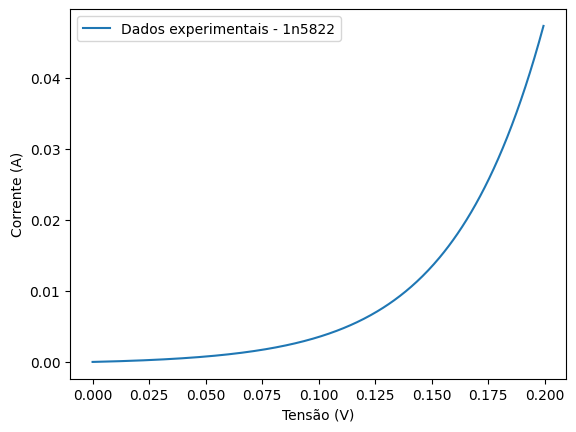

In [111]:
df = pd.read_csv("1n5822_curve.csv", sep = ";") 
df.drop(df.columns[[2]], axis=1, inplace=True)

df = df[df['vd'] < 0.2]

plt.plot(df["vd"].values, df["id"].values,label='Dados experimentais - 1n5822')
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.legend()
plt.show()

### Otimização dos parâmetros do diodo 

In [112]:
#escala dos parametros (para melhorar estab. numérica)
is_scale = 0.5
n_scale = 5
vt_scale = 4

# Define a equação de shockley
def shockley_equation(V, Is, n, Vt):
    return Is*is_scale * (np.exp(V / (n*n_scale * Vt*vt_scale)) - 1)


# faz o fitting da curva

#chute inicial
first_guess = [35e-3, 1, 25e-3]  # [Is, n, Vt]

vd = df["vd"].values
id = df["id"].values

popt, pcov = curve_fit(shockley_equation, vd, id, p0 = first_guess, method = "trf", bounds = (0, 50), ftol=1e-12, xtol=1e-12)

Is, n, Vt = popt

#aplica as escalas
Is = is_scale*Is
n = n_scale*n
Vt = vt_scale*Vt

#valores otimizados encontrados
print("Is = ", Is)
print("n = ", n)
print("Vt = ", Vt)

Is =  0.0003100910934630034
n =  3.31460566723641
Vt =  0.011947302798393821


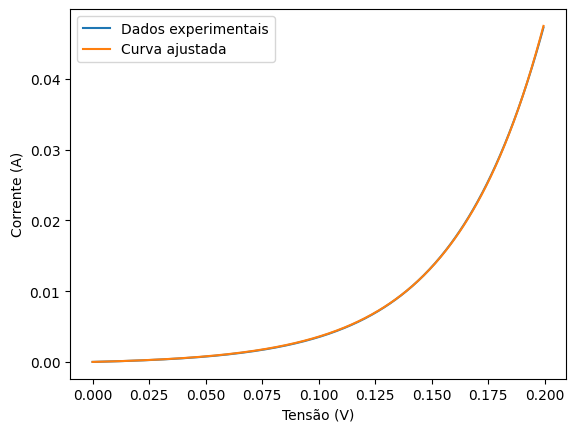

In [113]:
#plota ambas as curvas, o dados e a ajustada
plt.plot(vd, id,label='Dados experimentais')

id_fit = shockley_equation(vd, *popt)
plt.plot(vd, id_fit,label='Curva ajustada')
plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.legend()
plt.show()

### Plot saída vs ent

In [114]:
# Amplitudes (range) do sinal de entrada
A = np.arange(0,0.1, 0.0001)

# retorna valor da componente de saída DC no diodo em função da tensão de pico de entrada
# utilizando o desenvolvimento feito no tcc, por meio da função de Bessel modificada de primeiro grau
def dc_bessel_response(V):
    return Is*(np.i0(V/(n*Vt)) -1)


#aproximação apresentada em https://analog.intgckts.com/rf-power-detector/diode-detector-2/
def dc_site_response(V):
    return (Is/4)*((V/(n*Vt))**2)

#realiza o calculo para comparação
id_par = dc_bessel_response(A)
id_aprox = dc_site_response(A)

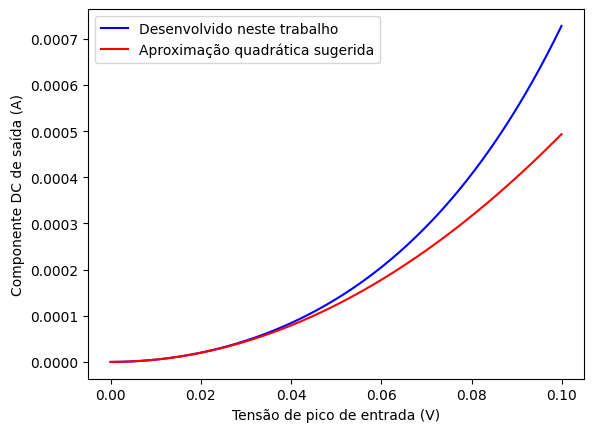

In [115]:
plt.plot(A, id_par, color= "blue", label = "Desenvolvido neste trabalho")
plt.plot(A, id_aprox, color = "red", label = "Aproximação quadrática sugerida")
plt.xlabel('Tensão de pico de entrada (V)')
plt.ylabel('Componente DC de saída (A)')
plt.legend()
plt.show()

## Comparação com simulador

Aqui comparamos os resultados obtidos por meio de simulação de balanço harmonico usando modelo spice do diodo 1n5822 utilizado na geração dos dados utilizados no fitting das curvas para o modelo de shockley (OBS: para níveis de tensão maiores que 0.2V temos dificuldade de encontrar os parametros de modelo de shockley adequados para o diodo em questão, portanto acima disto os valores podem ser incoerentes)

### Calculo estimado usando fórmula desenvolvida

In [123]:
df2 = pd.read_csv("dc_component.csv", sep = ";") 
df2.drop(df2.columns[[2]], axis=1, inplace=True)

#para remover divisão por zero no calculo percentual por conta que Vin = 0 -> id = 0
df2 = df2[df2['vin'] > 0]
df2 = df2[df2['vin'] < 0.25]
df2.head()

,vin,id
1,0.001,4.794000e-08
2,0.002,1.917420e-07
3,0.003,4.314920e-07
4,0.004,7.673100e-07
5,0.005,1.199360e-06


In [124]:
vin = df2["vin"].values
id_medido = df2["id"].values

#realiza o calculo para comparação
id_bessel = dc_bessel_response(vin)
id_aprox = dc_site_response(vin)

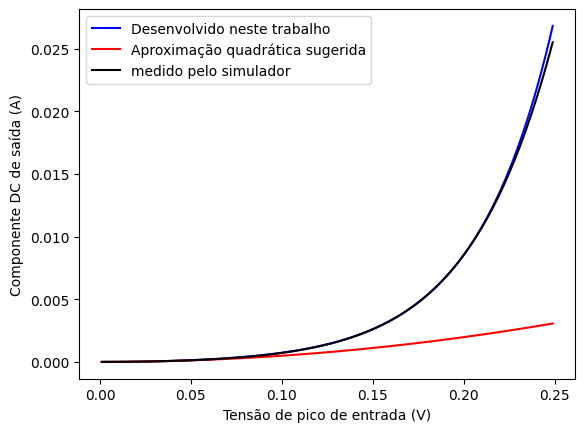

In [125]:
plt.plot(vin, id_bessel, color= "blue", label = "Desenvolvido neste trabalho")
plt.plot(vin, id_aprox, color = "red", label = "Aproximação quadrática sugerida")
plt.plot(vin, id_medido, color = "black", label = "medido pelo simulador")
plt.xlabel('Tensão de pico de entrada (V)')
plt.ylabel('Componente DC de saída (A)')
plt.legend()
plt.show()

Conforme a imagem acima, é possível perceber que os os valores encontrados segundo a simulação são coincidentes com os formulados matemáticamente

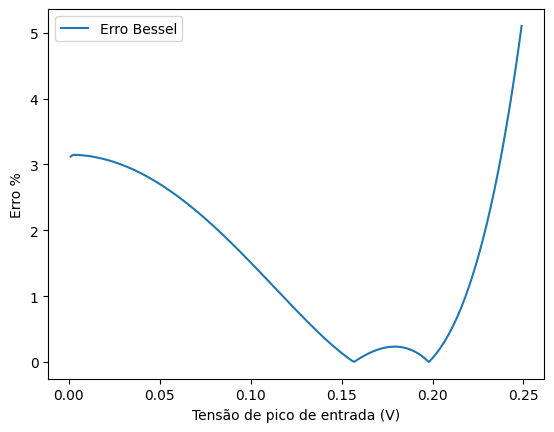

In [129]:
#calcula os erros percentuais
erro_pct_bessel = np.abs((id_medido - id_bessel)/id_medido)*100
erro_pct_aprox = np.abs((id_medido - id_aprox)/id_medido)*100

plt.plot(vin, erro_pct_bessel, label = "Erro Bessel")
plt.xlabel('Tensão de pico de entrada (V)')
plt.ylabel('Erro %')
plt.legend()
plt.show()

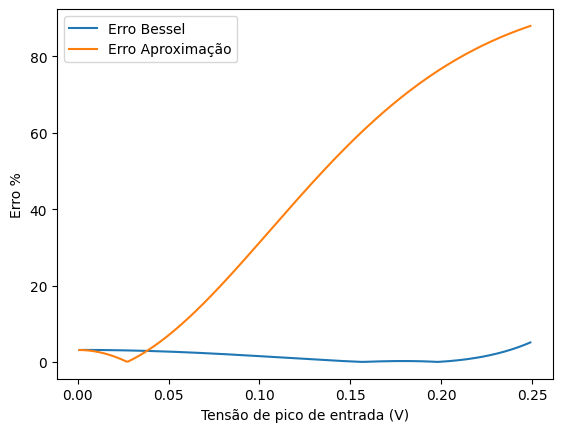

In [131]:
plt.plot(vin, erro_pct_bessel, label = "Erro Bessel")
plt.plot(vin, erro_pct_aprox, label = "Erro Aproximação")
plt.xlabel('Tensão de pico de entrada (V)')
plt.ylabel('Erro %')
plt.legend()
plt.show()

In [ ]:
plt.plot(vin, erro_pct_aprox, label = "Erro Aproximação")
plt.xlabel('Tensão de pico de entrada (V)')
plt.ylabel('Erro %')
plt.legend()
plt.show()

É fácil perceber a vantagem da resposta calculada, quando comparada com a aproximação e os dados de simulação. 